# Building a tweet classifier in Python

I think it's fair to say that we are currently living in a particularly partisan era of politics. This coupled with the rise of populist figures such as Trump, Sanders, and Corbyn makes politics an interesting time. Twitter makes things even more interesting because it lets our politicians interact with us directly to our phones. In the case of Donald Trump, the results of this are equally fascinating and horrifying.

This leads me to the question "can we build a machine learning model to tell us who wrote a given tweet?". I am fairly certain the answer to this question is "yes", so I am going to put my findings in this notebook.

## Step 1: Collecting the data

There is a script in this folder called get_tweets.py, which uses Tweepy to scrape the most recent 3,000 or so tweets from a number of accounts. The ones I chose for this were those of Donald Trump, Barack Obama, Hillary Clinton, Bernie Sanders, and... me. I would recommend the reader takes time to familarise themselves with this script if they intend to do something similar.

## Step 2: Pre-Processing the data
All the tweets I collected are in a text file, each on a line, with the tweet and the user separated by ',::,' (I wanted a delimiter that was unlikely to come up in the course of a normal tweet). I am going to load some packages that we need to use and then store all of the tweets into a dataframe.

In [1]:
#Let's import all the libraries we might need to use
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_tweets(txt_file):
    '''
    Read the tweets from the text file generated by get_tweets.py and store
    them in a pandas datafram
    '''
    #Make a list of lists, where each sub list is [tweet,user]
    tweet_list = []
    labels = ['Tweet','User']
    with open(txt_file,'r') as tweets:
        for line in tweets:
            tweet_list.append(line.split(',::,'))

    #Create the df, drop any rows where User == None and see the first 5 entries
    tweet_df = pd.DataFrame.from_records(tweet_list,columns = labels)
    tweet_df = tweet_df.dropna(axis=0)
    return tweet_df

tweet_df = load_tweets('tweets.txt')

We will be using the 'bag of words' approach as a basis. To start with, we will be trying out models built with Random Forests and Naive Bayes classifiers. We will see how each of these gets on and then evaluate our next step. But first we need to tokenise our data, and remove the stop words, and then run our TF-idf vectoriser on them to get a sparse matrix for use with our classifiers.

In [3]:
#set tokeniser, stemmer, stopwords, and TF_idf vectoriser
tokeniser = RegexpTokenizer('\w+')
stemmer = SnowballStemmer('english')
sw = stopwords.words('english')
tf_idf = TfidfVectorizer()

#there will be some links in the tweets that probably won't help
#let's add some extra stop words
link_text_words = ['http','https','com','co','www','ly']
for word in link_text_words:
    sw.append(word)

def text_processor(doc,df):
    '''
    takes document and does the tokenisation, stemming, and removal
    of stopwords. Then appends this to the dataframe
    '''
    tokens = tokeniser.tokenize(doc)
    #remove the stop words
    filtered_words = []
    for token in tokens:
        if token not in sw:
            filtered_words.append(token)
    
    #stem the remaining words
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    
    return ' '.join(stemmed_words)
#process all the tweets and add them to the dataframe
def tokenise_tweets(df):
    '''
    takes a dataframe and creates a new list to be appended as a column of
    tokenised and processed tweets. Also produces a numpy array of tf_idf
    of the tokens
    '''
    df['Tokens'] = [text_processor(tweet,df) for tweet in df['Tweet']]

    return tf_idf.fit_transform(df['Tokens'])

X = tokenise_tweets(tweet_df)

We have cleaned our tweets ready for classification, but we need numerical values for our users. We will use the scikit learn label encoder that we imported earlier.

In [4]:
def label_users(df):
    'gives a numerical value for user ID'
    user_le = LabelEncoder()
    df['User ID'] = user_le.fit_transform(df['User'].astype(str))

label_users(tweet_df)

We have done our TFidf, we have given numerical labels to our users, let's have a go at training some models. We will need to split our data into training and test data, remembering that the way the data was read into the dataframe, the tweets are currently sorted by class. We will need to make sure the data is shuffled before splitting. Luckily, train_test_split will do that for us.

In [5]:
y = tweet_df['User ID'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


Now we have split the data, we can fit our models and see how they perform. As previously mentioned, we are going to try with a multinomial Naive Bayes classifier and a random forest. The MultinomialNB is often used for textual analysis, so I have high hopes for that

In [6]:
rf = RandomForestClassifier(n_estimators = 40)
mnb = MultinomialNB()

clfs = {'Random Forest':rf,
        'Multinomial Naive Bayes':mnb}

for k,v in clfs.items():
    v.fit(X_train,y_train)
    y_pred = v.predict(X_test)
    acc = v.score(X_test,y_test)
    print(k,"Score:",acc)


Random Forest Score: 0.777950310559
Multinomial Naive Bayes Score: 0.809627329193


The Naive Bayes model is about 3% better than the Random Forest, which makes sense given the wide use of that algorithm for text classification. Let's see what it got wrong:

In [7]:
#Dict of User IDs to people:
tweeters = {0: 'Obama', 1: 'Sanders', 2: 'Trump', 3: 'Clinton', 4: 'Blood'}
#get all our prediction data
y_pred = mnb.predict(X_test)
predictions = zip(X_test, y_test, y_pred)

#print out the corpus, user, and predicted user for the failures
for p in predictions:
    if p[1] != p[2]:
        print(
            tf_idf.inverse_transform(p[0]), 'Actual:', tweeters[p[1]],
            ', Predicted: ', tweeters[p[2]])

[array(['afternoon', 'beauti', 'break', 'grc', 'jelfscompchem',
       'legwpvlfoh', 'mountain', 'nanopor', 'nh', 'rt', 'trip', 'white'], 
      dtype='<U102')] Actual: Blood , Predicted:  Trump
[array(['61inovwczf', 'bad', 'deal', 'don', 'make', 'news', 'sander',
       'trump'], 
      dtype='<U102')] Actual: Sanders , Predicted:  Trump
[array(['afford', 'coverag', 'don', 'go', 'health', 'p8dqwo89c7', 'sign',
       'today', 'wait'], 
      dtype='<U102')] Actual: Sanders , Predicted:  Obama
[array(['htt'], 
      dtype='<U102')] Actual: Clinton , Predicted:  Blood
[array(['black', 'casino', 'dealer', 'fine', 'floor', 'one', 'regul',
       'remov', 'repeat', 'state', 'trump'], 
      dtype='<U102')] Actual: Clinton , Predicted:  Sanders
[array(['cissieglynch', 'evangel', 'k5kgxpr2wa', 'live', 'pdpryor1',
       'pynanc', 'saysgabriell', 'trumptow', 'women'], 
      dtype='<U102')] Actual: Trump , Predicted:  Clinton
[array(['nationalpetday', 'nvursfujq', 'side'], 
      dtype='<U102

A lot of the mistakes look like they have come from the use of shortened URLs that I didn't clean out of the data. Although one of my jokey tweets where I watched Schweinsteiger score for Chicago Fire was classified as being by Obama, presumably because he tweets about Chicago a lot.

I think 81% accuracy is pretty good for five separate classes with very little tuning of the model or the features. Before I get too carried away, however, let's cross-validate it to try to make sure we haven't over-fit our model.

In [8]:
kfold = StratifiedKFold(n_splits = 10,
                       random_state = 42)
#initialise list for accuracy scores
scores = []
#perform cv
for train,test in kfold.split(X,y):
    X_train, X_test = X[train],X[test]
    y_train, y_test = y[train],y[test]
    mnb.fit(X_train, y_train)
    y_pred = mnb.predict(X_test)
    score = mnb.score(X_test,y_test)
    scores.append(score)
    #print model information
    print('Acc %.3f' %score)

print ('mean_score: %.3f, standard deviation: %.3f' % (np.mean(scores),np.std(scores)))

Acc 0.702
Acc 0.838
Acc 0.813
Acc 0.812
Acc 0.806
Acc 0.827
Acc 0.797
Acc 0.800
Acc 0.790
Acc 0.767
mean_score: 0.795, standard deviation: 0.036


Our model was within one standard deviation of the mean accuracy score, so I think we can be pretty confident that our model should be generalisable to any unseen data.

Before we finish, however, let's just look at a confusion matrix and see how we did.

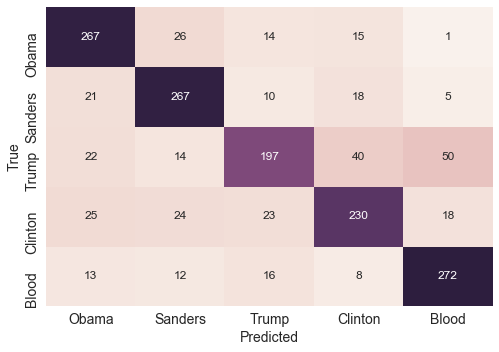

In [9]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(
    conf_mat,
    annot=True,
    cbar=False,
    yticklabels=['Obama', 'Sanders', 'Trump', 'Clinton', 'Blood'],
    xticklabels=['Obama', 'Sanders', 'Trump', 'Clinton', 'Blood'],
    fmt='d')
plt.xlabel('Predicted', size=14)
plt.ylabel('True', size=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

This confusion matrix is a little disconcerting, as it seems to be suggesting that I am most easily confused with Donald Trump. I suppose I had better go off and Make America Great Again.

## A Binary system: Trump/Obama

We have 81% accuracy when classifying between 5 people, let's do this project the wrong way round and see what happens when it's just between 2 people: Both of whom have been 'Leader of the Free World (TM)' (I REALLY hate that phrase). Let's load our Trump and Obama tweets and get our X & y values.

In [10]:
trumbama = load_tweets('trump_obama.txt')
X = tokenise_tweets(trumbama)
label_users(trumbama)
y = trumbama['User ID'].values
trumbama.head()

,Tweet,User,Tokens,User ID
0,"Just watched a very insecure Oprah Winfrey, wh...",Donald J. Trump\n,just watch insecur oprah winfrey one point i k...,1
1,My great friends from NASCAR are having their ...,Donald J. Trump\n,my great friend nascar big race today the dayt...,1
2,"Thank you to KenStarr, former Independent Coun...",Donald J. Trump\n,thank kenstarr former independ counsel whitewa...,1
3,Great Pollster John McLaughlin now has the GOP...,Donald J. Trump\n,great pollster john mclaughlin gop generic con...,1
4,The Fake News of big ratings loser CNN. https:...,Donald J. Trump\n,the fake news big rate loser cnn rysv90cnv,1


Ok, now we can train our two classifiers again and see how well they do when there is only two classes.

In [11]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=40)
mnb = MultinomialNB()

clfs = {'Random Forest': rf, 'Multinomial Naive Bayes': mnb}

for k, v in clfs.items():
    v.fit(X_train, y_train)
    y_pred = v.predict(X_test)
    acc = v.score(X_test, y_test)
    print(k, "Score:", acc)

Random Forest Score: 0.905092592593
Multinomial Naive Bayes Score: 0.935185185185


Blimey! 93.5% accuracy for the MNB model. Let's check it's not a fluke due to overfitting, then we can start to look at some metrics other than score.

In [12]:
kfold = StratifiedKFold(n_splits = 10,
                       random_state = 42)
#initialise list for accuracy scores
scores = []
#perform cv
for train,test in kfold.split(X,y):
    X_train, X_test = X[train],X[test]
    y_train, y_test = y[train],y[test]
    mnb.fit(X_train, y_train)
    y_pred = mnb.predict(X_test)
    score = mnb.score(X_test,y_test)
    scores.append(score)
    #print model information
    print('Acc %.3f' %score)

print ('mean_score: %.3f, standard deviation: %.3f' % (np.mean(scores),np.std(scores)))

Acc 0.889
Acc 0.918
Acc 0.929
Acc 0.914
Acc 0.941
Acc 0.912
Acc 0.896
Acc 0.913
Acc 0.923
Acc 0.850
mean_score: 0.909, standard deviation: 0.024


Our score is a little larger than 1 standard deviation from the mean, but I feel confident enough that we haven't overfit the model.

Let's look at a confusion matrix to see how our original model did.

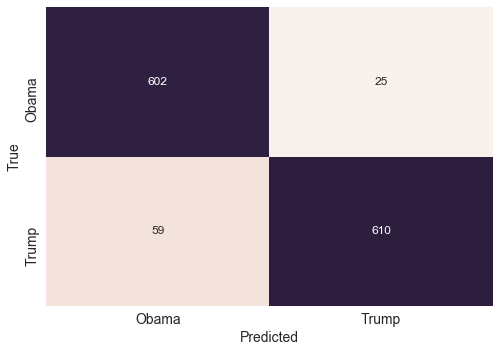

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(
    conf_mat,
    annot=True,
    cbar=False,
    yticklabels=['Obama', 'Trump'],
    xticklabels=['Obama', 'Trump'],
    fmt='d')
plt.xlabel('Predicted', size = 14)
plt.ylabel('True', size =14)
plt.tick_params(axis='both',which='major',labelsize=14)
plt.show()